<a href="https://colab.research.google.com/github/Driptoe0606/ChemGAN-challenge/blob/master/Removal_of_Unwanted_Compounds_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Removal of the Unwanted Compounds From the Dataset**

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x

### Contents in Learn

* Load and visualize data
* Filter for PAINS
* Filter for unwanted substructures
* Highlight substructures
* Substructure statistics

### References

* Pan Assay Interference compounds ([wikipedia](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds), [_J. Med. Chem._ (2010), **53**, 2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j))
* Unwanted substructures according to Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 435-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139))
* Inspired by a Teach-Discover-Treat tutorial ([repository](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb))
* RDKit ([repository](https://github.com/rdkit/rdkit), [documentation](https://www.rdkit.org/docs/index.html))

## **Basic Concepts**

### Unwanted substructures

Substructures can be unfavorable, e.g., because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays.
Nowadays, drug discovery campaigns often involve [high throughput screening](https://en.wikipedia.org/wiki/High-throughput_screening). Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources.

Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 435-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) have assembled a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.

### Pan Assay Interference Compounds (PAINS)

[PAINS](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds) are compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target. Such behavior results from unspecific binding or interaction with assay components. Baell *et al.* ([_J. Med. Chem._ (2010), **53**, 2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.

![PAINS](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T003_compound_unwanted_substructures/images/PAINS_Figure.jpeg?raw=1)

Figure 1: Specific and unspecific binding in the context of PAINS. Figure taken from [Wikipedia](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif).

## Practical

### Load and visualize data

###Installation and Imports

In [1]:
! pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.8 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
# Load the data generated in Part-2
hsp70_data = pd.read_csv('/content/ro5_properties_filtered.csv',
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", hsp70_data.shape)
hsp70_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
hsp70_data.head()

Dataframe shape: (42, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL502775,332,nM,O=C(O)/C=C/c1c2ccc(=O)c(O)c-2oc2c(O)c(O)ccc12,6.478862,True
1,CHEMBL1481974,578,nM,O=C(O)CCc1c2ccc(=O)c(O)c-2oc2c(O)c(O)ccc12,6.238072,True
2,CHEMBL471004,634,nM,CC1C2C=CC1C(c1c3ccc(=O)c(O)c-3oc3c(O)c(O)ccc13...,6.197911,True
3,CHEMBL6246,760,nM,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,6.119186,True
4,CHEMBL1409373,1970,nM,NS(=O)(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,5.705534,True


Failed to patch pandas - unable to change molecule rendering


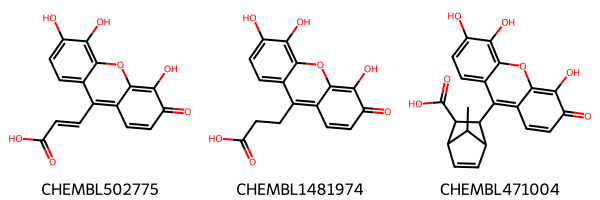

In [4]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(hsp70_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(hsp70_data.head(3).ROMol),
    legends=list(hsp70_data.head(3).molecule_chembl_id),
)

### Filter for PAINS

The PAINS filter is already implemented in RDKit ([documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)). Such pre-defined filters can be applied via the `FilterCatalog` class.

In [5]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [6]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(hsp70_data.iterrows(), total=hsp70_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
hsp70_data = hsp70_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/42 [00:00<?, ?it/s]

In [7]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(hsp70_data)}")

Number of compounds with PAINS: 35
Number of compounds without PAINS: 7


The first 3 identified PAINS.

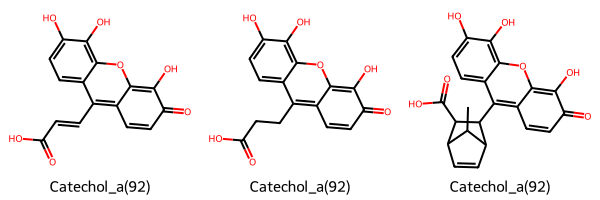

In [8]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

### Filter and highlight unwanted substructures

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually.
Here, I used the list provided in the supporting information from Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 535-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).

In [11]:
substructures = pd.read_csv("/content/unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


First 3 substructures.

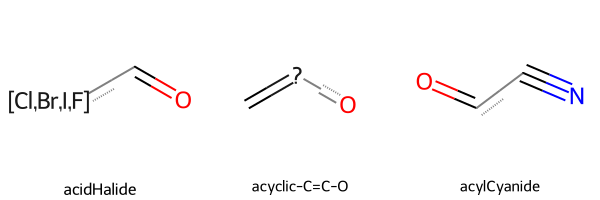

In [12]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

Search the filtered dataframe for matches with these unwanted substructures.

In [13]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(hsp70_data.iterrows(), total=hsp70_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
hsp70_data = hsp70_data.loc[clean]

  0%|          | 0/7 [00:00<?, ?it/s]

In [14]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(hsp70_data)}")

Number of found unwanted substructure: 5
Number of compounds without unwanted substructure: 4


### Highlight substructures

The first 3 identified unwanted substructures. Since accessible to  underlying SMARTS patterns, I can highlight the substructures within the RDKit molecules.

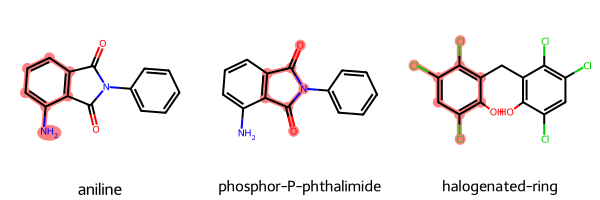

In [18]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

### Substructure statistics

Finally, find most frequent substructure found in our data set. The Pandas `DataFrame` provides convenient methods to group containing data and to retrieve group sizes.

In [16]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

,0
substructure_name,
Oxygen-nitrogen-single-bond,1
aniline,1
halogenated-ring,1
nitro-group,1
phosphor-P-phthalimide,1


## Discussion
There are two possibilities to perform a search for unwanted substructures with RDKit:

* The `FilterCatalog` class can be used to search for predefined collections of substructures, e.g., PAINS.
* The `HasSubstructMatch()` function to perform manual substructure searches.

Actually, PAINS filtering could also be implemented via manual substructure searches with `HasSubstructMatch()`. Furthermore, the substructures defined by Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 535-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) are already implemented as a `FilterCatalog`. Additional pre-defined collections can be found in the RDKit [documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html).

So far, I have been using the `HasSubstructMatch()` function, which only yields one match per compound. With the `GetSubstructMatches()` function ([documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html)) one could identify all occurrences of a particular substructure in a compound.
In case of PAINS, I have only looked at the first match per molecule (`GetFirstMatch()`). However, I could also use `GetMatches()` in order to see all critical substructures of a molecule, not just simply all PAINS.

Detected substructures can be handled in two different fashions:

* Either, the substructure search is applied as a filter and the compounds are excluded from further testing to save time and money.
* Or, they can be used as warnings, since ~5 % of FDA-approved drugs were found to contain PAINS ([_ACS. Chem. Biol._ (2018), **13**, 36-44](https://pubs.acs.org/doi/10.1021/acschembio.7b00903)). In this case experts can judge manually, if an identified substructure is critical or not.